# Problem 2.7

From a hamiltonian point of view, study a charged particle moving in the field created by a magnetic dipole. Prove that there are solutions constrained to the plane perpendicular to the magnetic moment. Analyze qualitatively the dynamics in this plane

In this notebook I solve part of this problem. In particular I focus in the non-relativistic case, analyze the stability in the $z=0$ plane and compute the full numerical solution (nothing of this is asked for in the exercise). I leave to you the relativistic case and the discussion of the existence of bound orbits in the $z=0$ plane.

In [1]:
import numpy as np
import hvr_functions as hvr
from scipy.integrate import odeint
from IPython.display import display
from sympy import *
from sympy.physics.vector import dynamicsymbols, init_vprinting

init_vprinting()

## Definition of the lagrangian

The lagrangian for this problem is

\begin{equation}
    L = -m\sqrt{1-\dot{\mathbf{r}}\cdot\dot{\mathbf{r}}} 
        + Q\ \dot{\mathbf{r}}\cdot \mathbf{A}\ ,
\end{equation}

where the magnetic potential is related to the magnetic moment as

\begin{equation}
    \mathbf{A} = \frac{\mathbf{M}\wedge\mathbf{r}}{r^3}\ .
\end{equation}

In [2]:
t = symbols('t')
m, M, QQ = symbols('m M Q')
L, H = symbols('L H')

I usually define the variables explicitly as $x,y,z$ and perform the matrix multiplication using list comprehensions. In this exercise I try to show you a different way using matrices, in case you like it most.

Two ways of automating the definition of variables

In [3]:
conf_vars = dynamicsymbols('x_(1:%d)' % 4)
display(conf_vars)

In this case I prefer letters labelling the coordinates

In [4]:
labels = ['x', 'y', 'z']

conf_vars = [dynamicsymbols('%s' % name) for name in labels]
display(conf_vars)

velocities = [q.diff() for q in conf_vars]
display(velocities)

momenta = [dynamicsymbols('p_%s' % name) for name in labels]
display(momenta)

mag_moment = [0, 0, M]
display(mag_moment)

Now I can use the `Matrix` variables to perform all the operations and compute the combinations that will go into the lagrangian.

In [5]:
r = Matrix(conf_vars)
r2 = r.dot(r)
display(r2)

dr = Matrix(velocities)
dr2 = dr.dot(dr)
display(dr2)

The magnetic potential is

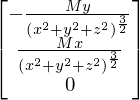

In [6]:
A = Matrix(mag_moment).cross(r)/sqrt(r2)**3
display(A)

Finally we have for the non-relativistic lagrangian

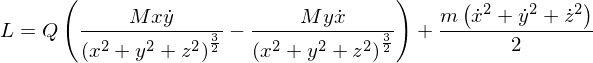

In [7]:
lagrangian = m*dr2/2 + QQ*dr.dot(A)

display( Eq(L, lagrangian) )

Next thing we do is to change to cylindrical coordinates

In [8]:
labels2 = ['rho', 'phi', 'z']
conf_vars_cyl = [dynamicsymbols('%s' % name) for name in labels2]
p, phi, z = conf_vars_cyl

momenta_cyl = [dynamicsymbols('p_%s' % name) for name in labels2]
pp, pphi, pz = momenta_cyl

change = [p*cos(phi), p*sin(phi), z]

cart_to_cyl = {q1 : q2 for q1, q2 in zip(conf_vars, change)}
display(cart_to_cyl)

and it is useful to define the radius

In [9]:
R = dynamicsymbols('R')

sub_radius = {p**2+z**2 : R**2}
sub_radius_inv = {R : sqrt(p**2+z**2)}
display(sub_radius)

The lagrangian in these coordinates is

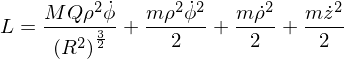

In [10]:
L_cyl = lagrangian.subs(cart_to_cyl).doit().simplify().subs(sub_radius)

display( Eq(L, L_cyl) )

We can avoid the annoying $(R^2)^{3/2}$ expression using simplification with assumptions

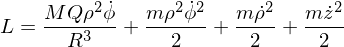

In [11]:
L_cyl = refine(L_cyl, Q.positive(R))  # Q belongs to sympy
display( Eq(L, L_cyl) )

## Hamiltonian and equations of motion

Now I am going to use my functions to find the hamiltonian from the lagrangian

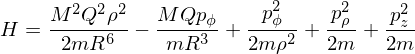

In [12]:
H_cyl = hvr.find_hamiltonian(t, conf_vars_cyl, momenta_cyl, L_cyl)
display( Eq(H, H_cyl) )

The hamiltonian can be further simplified defining the variable $J_z$ even though it is not necessary for the numerical computation that follows.

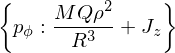

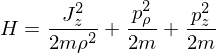

In [13]:
Jz = dynamicsymbols('J_z')

sub_Jz = {pphi : Jz + QQ*M*p**2/R**3}
sub_Jz_inv = {Jz : pphi - QQ*M*p**2/R**3}
display(sub_Jz)

display( Eq(H, H_cyl.subs(sub_Jz).simplify()) )

To find the equations of motion first I rewrite the hamiltonian with the original variables. Of course, in this particular problem (that can be done easily by hand) this is not the best approach, but the point of this exercise is to learn how to work with systems of equations using symbolic manipulators.

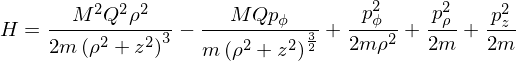

In [14]:
H_cyl = H_cyl.subs(sub_radius_inv)
display( Eq(H, H_cyl) )

Finally I find the equations of motion using my function.

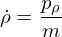

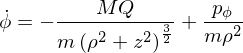

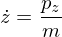

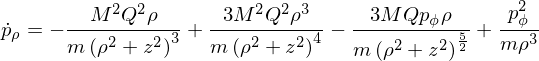

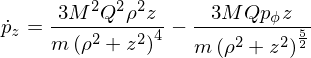

In [15]:
# define the whole list of canonical variables
can_vars = conf_vars_cyl + momenta_cyl

# find the equations of motion
system = hvr.eom_canonical(t, can_vars, H_cyl)

for eq in system:
    display(eq)

## Stability

We want to find out if the system has stable solutions confined to the plane $z=0$. First we can define the subsystem of interest

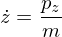

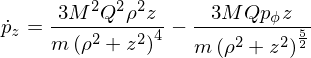

In [16]:
sub_sys = [system[2], system[-1]]

for eq in sub_sys:
    display(eq)

It can be checked immediately that $z=0$ and $p_z=0$ is a solution, but we want to know if it is stable. To that end, we can set up a perturbative expansion in $z$ and $p_z$. One way to make it automatic is

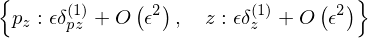

In [17]:
order = 2
eps = symbols('epsilon')

variables = [z, pz]
expansion = {var : 0 for var in variables}

for var in variables:
    # obtain the name without the (t) part
    str_rep = '_'.join(str(var)[:-3].split('_'))
    
    # define the symbols
    var_sym = dynamicsymbols('delta_%s__((1:%d))' % (str_rep, order))
    
    # create the expansion starting in eps=1
    for n, subvar in enumerate(var_sym):
        expansion[var] += subvar*eps**(n+1)
    
    expansion[var] += Order(eps**order) 
    
display(expansion)

We plug it into the equations of motion

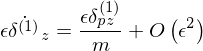

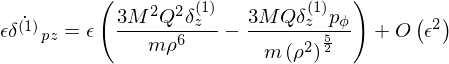

In [18]:
sub_sys_pert = [Eq(eq.lhs.subs(expansion).doit(), \
                   eq.rhs.subs(expansion).series(eps, 0, order)) \
                for eq in sub_sys]

for eq in sub_sys_pert:
    display(eq)

We keep only the terms that we want

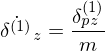

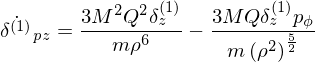

In [19]:
sub_sys_pert = [Eq(eq.lhs.coeff(eps), \
                   eq.rhs.coeff(eps)) \
                for eq in sub_sys_pert]

for eq in sub_sys_pert:
    display(eq)

and refine it a bit more

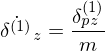

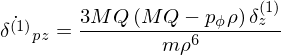

In [20]:
simp = lambda f: refine(f, Q.positive(p)).simplify()

sub_sys_pert = [Eq(eq.lhs, simp(eq.rhs)) for eq in sub_sys_pert]

for eq in sub_sys_pert:
    display(eq)

We have a linear system and to study its stability we need the matrix of its coefficients

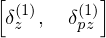

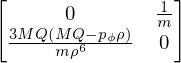

In [21]:
variables_pert = [q.subs(expansion).coeff(eps) for q in variables]
display(variables_pert)

coeff_matrix = [[eq.rhs.coeff(q) for q in variables_pert] \
                                 for eq in sub_sys_pert]
coeff_matrix = Matrix(coeff_matrix)

display(coeff_matrix)

Finally we can find the eigenvalues of this matrix

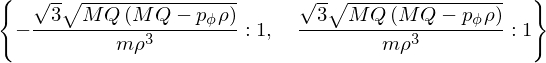

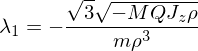

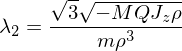

In [22]:
eigen = coeff_matrix.eigenvals()
display(eigen)

for i, eig in enumerate(eigen):
    display( Eq(Symbol('lambda_%d' % (i+1)), \
                eig.subs(sub_Jz).subs(R, p).simplify()) )

One of the eigenvalues is positive if $QJ_z<0$ so the solution is unstable in this case. If $QJ_z>0$ we have an oscillatory behaviour.

## Numerical solution

In the last section I solve numerically the original equations of motion

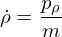

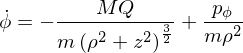

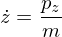

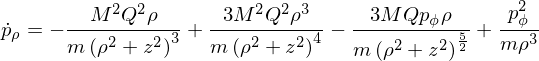

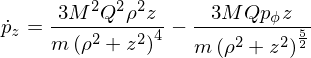

In [23]:
for eq in system:
    display(eq)

I use my own function to convert this symbolic system into a numerical one. I have also coded this function to return the jacobian of the right-hand side, very useful for the numerical algorithms but usually too expensive to compute it by hand. 

In [24]:
num_system, num_jac = hvr.symODE_to_numODE(system, can_vars, [QQ, M, m])

Note the `%time` instruction at the beginning of the cell, it times the execution of the cell. 

In [25]:
%time

nt = np.linspace(0, 200, 1000)

nQ = 1.
nM = 1.
nm = 1.

phi0 = 0.
z0 = 0.05
pp0 = 0.
pphi0 = 1.
pz0 = 0.

p0 = 1.2*nQ*nM/pphi0

ini_con = [p0, phi0, z0, pp0, pphi0, pz0]

solution = odeint(num_system, \
                  ini_con, \
                  nt, \
                  args=(nQ, nM, nm), \
                  Dfun=num_jac).transpose()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


<IPython.core.display.Javascript object>


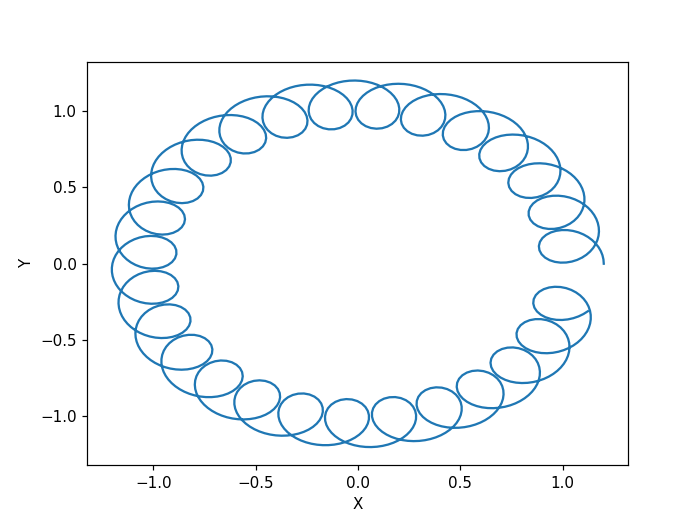

<IPython.core.display.Javascript object>


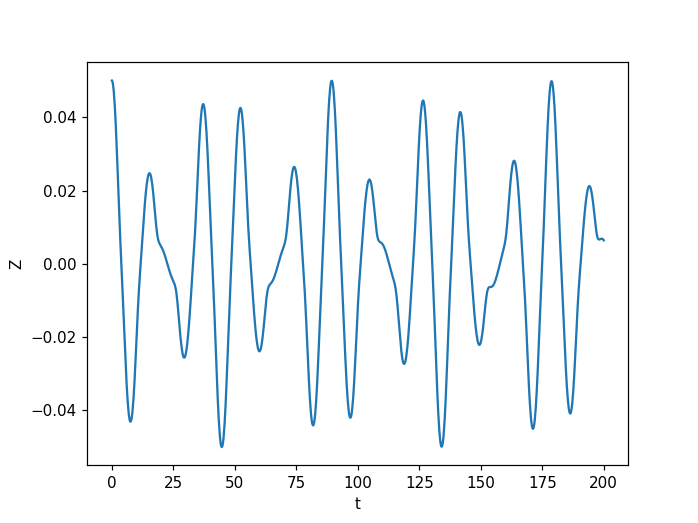

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt

rho, nphi, nz, npp, npphi, npz = solution
X = rho*np.cos(nphi)
Y = rho*np.sin(nphi)

plt.figure(1)
plt.plot(X, Y)
plt.xlabel('X')
plt.ylabel('Y')

plt.figure(2)
plt.plot(nt, nz)
plt.xlabel('t')
plt.ylabel('Z');

We can plot it in 3d as well

<IPython.core.display.Javascript object>


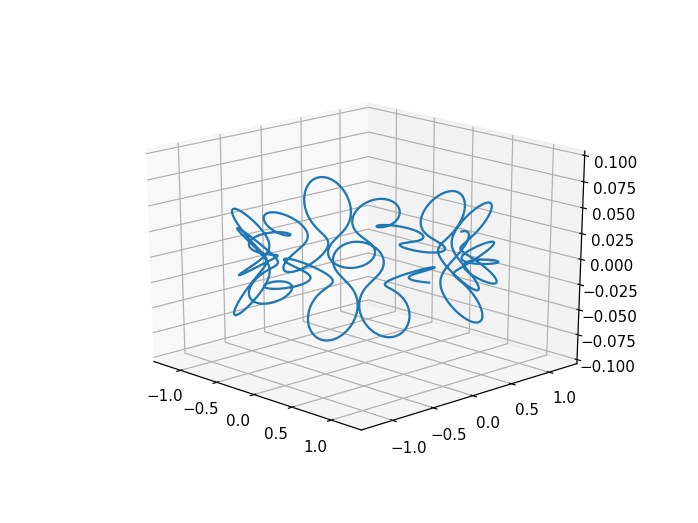

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(3)
ax = plt.axes(projection='3d')
ax.plot(X, Y, nz)

ax.set_zlim(-0.1, 0.1);